### Import libraries 

In [2]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import torchvision 
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from  torch.autograd import Variable
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
from sklearn.metrics import accuracy_score
import random

### Plot confusion matrix

In [3]:
def plot_confusion_matrix(y_valid, y_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_valid, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Trainging and testing dataset

In [4]:
trainset = torchvision.datasets.MNIST('./datasets/MNIST_data', train=True, download=True )
print('Length of training set ',len(trainset))
#download mnist validation dataset and sample it 
testset = torchvision.datasets.MNIST('./datasets/MNIST_data', train=False, download=True)
print('Length of testseting set ',len(testset))
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

Length of training set  60000
Length of testseting set  10000


### Show a batch of images

In [5]:
def show_batch():
        
    len_dataset = len(trainset)
    
    #sample some images 
    rlst = random.sample(range(len_dataset), 9)
                         
    #loop over the indices and plot the images as sub-figures 
    j = 0 
    for i in rlst:
        img , lbl = trainset[i]
        img =  img.resize((300, 300), Image.ANTIALIAS)
        img = np.array(img)
        plt.subplot(3, 3, j + 1)
        plt.title(classes[lbl])
        plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
        plt.imshow(img, cmap='gray')
        
        j+=1
    plt.show()

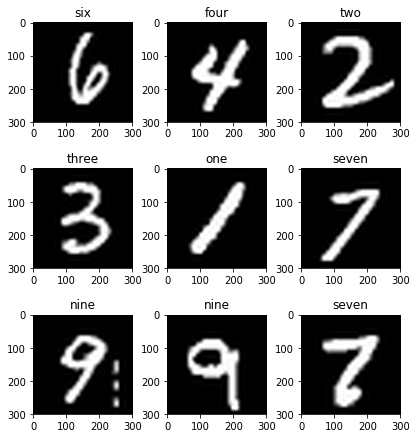

In [6]:
show_batch()

### Sample data from training and validation 

Download the data set if it doesn't exist and use the sampler to divide it using the batch size 

In [7]:
batch_size = 128

#download mnist training dataset and sample it 
trainset = torchvision.datasets.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size,
                         )

#download mnist validation dataset and sample it 
testset = torchvision.datasets.MNIST('./datasets/MNIST_data', train=False, download=True,
                           transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size)

### Flatten the data for fully connected layers

In order to forward the current patch of size $(N,C,H,W)$ we have to reshape it to size $(N,C \times H  \times W)$ 

In [8]:
class Flatten(nn.Module):
    def forward(self,x):
        N,_,_,_ = x.size()
        return x.view(N,-1)

### Model design 

The function which a signle convolution layer + relu + norm + pool + 2FC layers 

In [15]:
model=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size=7,stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.MaxPool2d(kernel_size=2,stride=2),
                    Flatten(),
                    nn.Linear(3872,1024), 
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )

In [16]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [17]:
if use_gpu:
    model = model.cuda()

### Optimizer 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Trianer 

In [19]:

def train_model(model, criterion, optimizer,show_confusion_matrix = True,  num_epochs=5):
    since = time.time()

    best_acc = 0.0
    best_lbl_prd = []
    best_lbl_tru = []
        
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

         # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            i = 0 
                
            loader = trainloader
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                loader = testloader 
            
            #calculate epoch loss
            running_loss = 0.0
            running_corrects = 0
            
            #save predictted and tru labeling 
            lbl_prd_val = [] 
            lbl_tru_val = []
            
            # Iterate over data.
            cnt = 0 
            for i_batch, batch in enumerate(loader):
                
                # get the inputs ,lbls of the batch 
                inputs , labels = batch 
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.float().cuda())
                    labels = Variable(labels.long().cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                #evaluate the loss
                loss = criterion(outputs, labels)
                
                #backprop in training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    lbl_tru_val = np.concatenate((lbl_tru_val , labels.data.cpu().numpy()),0)
                    lbl_prd_val = np.concatenate((lbl_prd_val , preds.cpu().numpy()),0)
                    
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                i+=1
            #evaluate the model according to type
            if phase =='train':
                len_dataset = len(trainset)
            else:
                len_dataset = len(testset)

            epoch_loss = running_loss / len_dataset
            epoch_acc = running_corrects / len_dataset
            
            #pickup the best validation accuracy with the labeling 
            if phase == 'val':
                if best_acc < epoch_acc:
                    best_acc = epoch_acc
                    best_lbl_prd = lbl_prd_val
                    best_lbl_tru = lbl_tru_val

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #show confusion matrix 
    if show_confusion_matrix:
        plot_confusion_matrix(best_lbl_tru , best_lbl_prd)
        
    return model

Epoch 0/4
----------
train Loss: 0.0008 Acc: 0.9670
val Loss: 0.0005 Acc: 0.9788
Epoch 1/4
----------
train Loss: 0.0002 Acc: 0.9909
val Loss: 0.0004 Acc: 0.9838
Epoch 2/4
----------
train Loss: 0.0001 Acc: 0.9936
val Loss: 0.0005 Acc: 0.9855
Epoch 3/4
----------
train Loss: 0.0001 Acc: 0.9955
val Loss: 0.0005 Acc: 0.9858
Epoch 4/4
----------
train Loss: 0.0001 Acc: 0.9954
val Loss: 0.0007 Acc: 0.9799
Training complete in 2m 58s
Best val Acc: 0.985800
Confusion matrix, without normalization


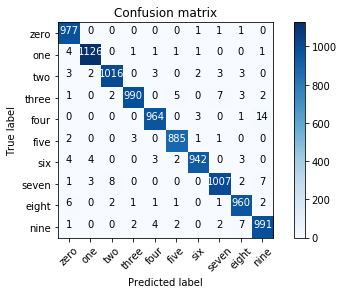

In [20]:
trained_model = train_model(model, criterion, optimizer)